# Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import pipe_newb, pipe_broken, pipe_rental

In [43]:
# 커스텀 파라미터
# 모든 열 보이게
pd.set_option('display.max_columns', None)
# 과학적 표기법 사용하지 않기
pd.set_option('display.float_format', lambda x: f'{x:.4f}')
# 시각화 한국말 디스플레이
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['AppleGothic']

# Ensure minus sign is rendered correctly by using the default minus sign
plt.rcParams['axes.unicode_minus'] = False

# # Reset rcParams to default
# plt.rcdefaults()

# 데이터 불러오기

In [3]:
df_newb = pd.read_parquet('./data/원본/parquet/신규가입자정보.parquet', engine='pyarrow')
df_rental = pd.read_parquet('./data/원본/parquet/대여이력정보.parquet', engine='pyarrow')
df_broken = pd.read_parquet('./data/원본/parquet/고장신고내역.parquet', engine='pyarrow')

In [4]:
df_newb = pipe_newb(df_newb)
df_rental = pipe_rental(df_rental)
df_broken = pipe_broken(df_broken)

# 가공 데이터에 저장

In [5]:
# df_newb.to_csv('./data/가공데이터/신규가입자정보.csv', index=False)
# df_rental.to_csv('./data/가공데이터/대여이력정보.csv', index=False)
# df_broken.to_csv('./data/가공데이터/고장신고내역.csv', index=False)

# 기술통계

신규가입자 통계량 확인

In [6]:
df_newb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype    
---  ------  --------------  -----    
 0   가입일시    12 non-null     period[M]
 1   가입건수    12 non-null     int64    
dtypes: int64(1), period[M](1)
memory usage: 320.0 bytes


In [7]:
df_newb.describe()

,가입건수
count,12.0000
mean,45790.8333
std,22020.6702
min,11530.0000
25%,32885.7500
50%,48251.0000
75%,61461.0000
max,81574.0000


대여이력정보 통계량 확인

In [8]:
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24872129 entries, 0 to 24872128
Data columns (total 7 columns):
 #   Column   Dtype         
---  ------   -----         
 0   자전거번호    object        
 1   대여일시     datetime64[ns]
 2   이용시간(분)  int64         
 3   이용거리(M)  float64       
 4   대여대여소ID  object        
 5   반납대여소ID  object        
 6   나이(만)    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.3+ GB


In [9]:
df_rental.describe(include=['int64', 'float64'])

,이용시간(분),이용거리(M),나이(만)
count,24872129.0000,24872129.0000,24872129.0000
mean,20.1154,2742.4550,33.6505
std,13.7041,2064.2646,11.5359
min,5.0000,1000.0000,14.0000
25%,10.0000,1400.0000,25.0000
50%,15.0000,1992.8600,31.0000
75%,27.0000,3240.0000,42.0000
max,60.0000,15000.0000,64.0000


In [10]:
df_broken.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194728 entries, 0 to 194727
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   자전거번호   194728 non-null  object        
 1   등록일시    194728 non-null  datetime64[ns]
 2   고장구분    194728 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 4.5+ MB


In [11]:
df_broken.describe(include='object')

,자전거번호,고장구분
count,194728,194728
unique,39409,6
top,SPB-59807,기타
freq,41,53952


## 시각화

In [12]:
print(f"{df_newb.columns = }")
print(f"{df_rental.columns = }")
print(f"{df_broken.columns = }")

df_newb.columns = Index(['가입일시', '가입건수'], dtype='object')
df_rental.columns = Index(['자전거번호', '대여일시', '이용시간(분)', '이용거리(M)', '대여대여소ID', '반납대여소ID', '나이(만)'], dtype='object')
df_broken.columns = Index(['자전거번호', '등록일시', '고장구분'], dtype='object')


# 신규가입자, 대여이력정보


In [68]:
df_newb_groupby = (
    df_newb
    .groupby([df_newb['가입일시'].dt.year.rename('year'), df_newb['가입일시'].dt.month.rename('month')])
    .agg({'가입건수':'sum'})
    .reset_index()    
)
df_newb22_groupby = (
    df_newb_groupby
    .loc[df_newb_groupby['year'] == 2022]
    .assign(가입건수_변화량= lambda x: x['가입건수'].pct_change().fillna(0))
) 
df_newb23_groupby = (
    df_newb_groupby
    .loc[df_newb_groupby['year'] == 2023]
    .assign(가입건수_변화량= lambda x: x['가입건수'].pct_change().fillna(0))
) 
df_newb_groupby = pd.concat([df_newb22_groupby, df_newb23_groupby])

In [67]:
df_rental_groupby = (
    df_rental
    .groupby([df_rental['대여일시'].dt.year.rename('year'), df_rental['대여일시'].dt.month.rename('month')])
    .agg({'자전거번호':'size'})
    .reset_index()
) 
df_rental22_groupby = (
    df_rental_groupby
    .loc[df_rental_groupby['year'] == 2022]
    .assign(대여건수_변화량= lambda x: x['자전거번호'].pct_change().fillna(0))
) 
df_rental23_groupby = (
    df_rental_groupby
    .loc[df_rental_groupby['year'] == 2023]
    .assign(대여건수_변화량= lambda x: x['자전거번호'].pct_change().fillna(0))
) 
df_rental_groupby = pd.concat([df_rental22_groupby, df_rental23_groupby])

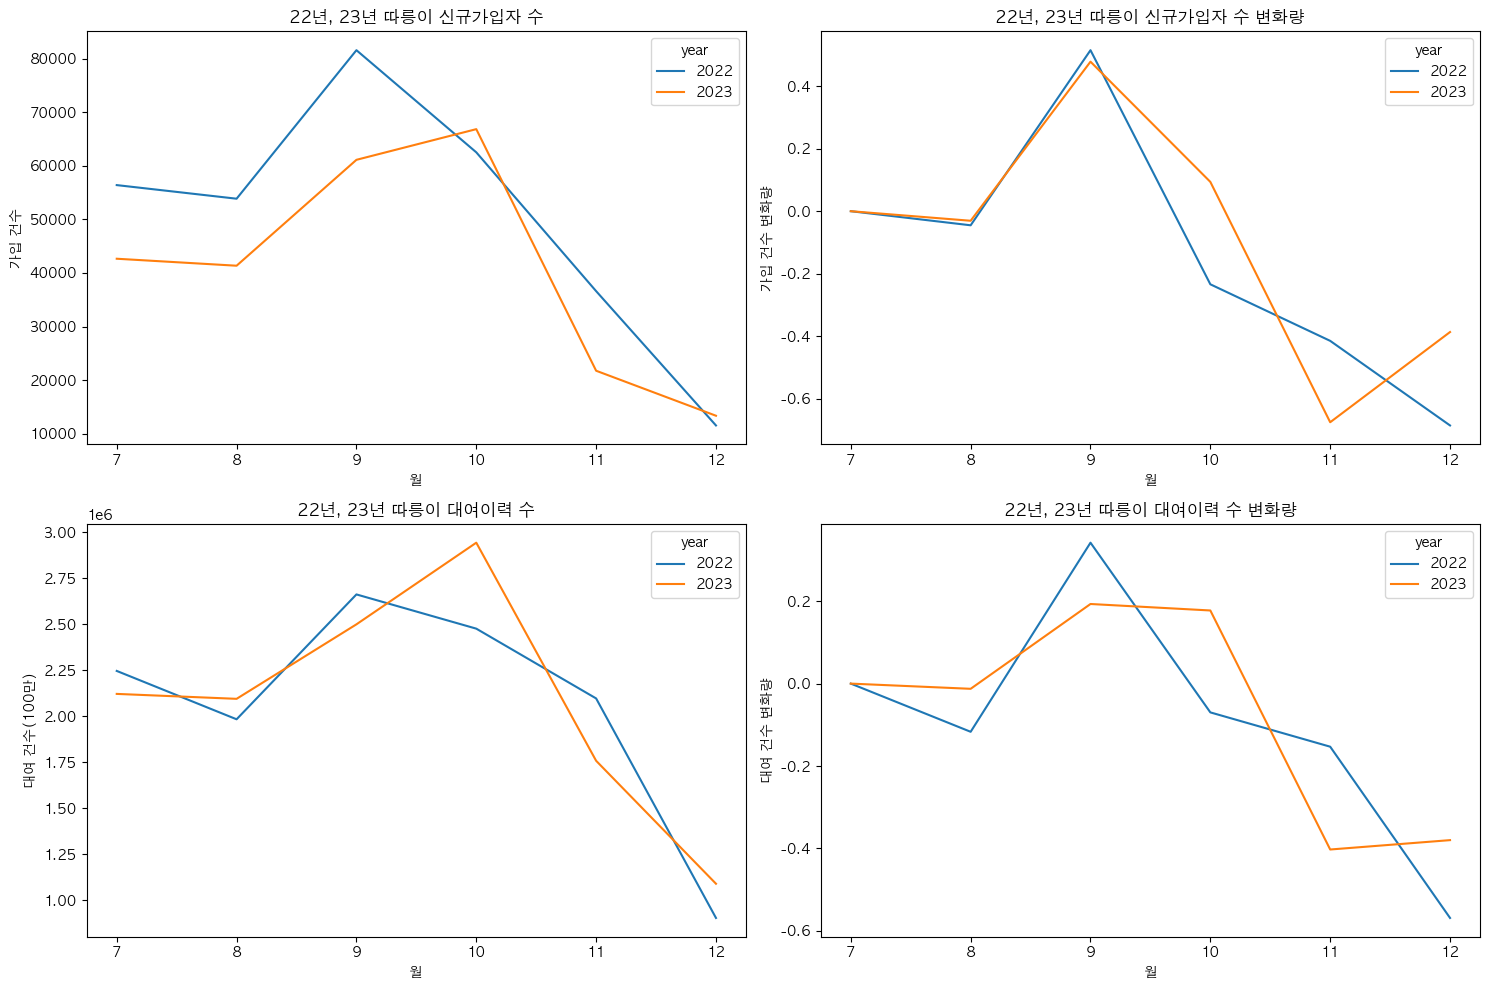

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

df_newb_groupby.pivot(index='month', columns='year', values='가입건수').plot(kind='line', ax=axs[0, 0])
axs[0, 0].set_title('22년, 23년 따릉이 신규가입자 수')
axs[0, 0].set_xlabel('월')
axs[0, 0].set_ylabel('가입 건수')

df_newb_groupby.pivot(index='month', columns='year', values='가입건수_변화량').plot(kind='line', ax=axs[0, 1])
axs[0, 1].set_title('22년, 23년 따릉이 신규가입자 수 변화량')
axs[0, 1].set_xlabel('월')
axs[0, 1].set_ylabel('가입 건수 변화량')

df_rental_groupby.pivot(index='month', columns='year', values='자전거번호').plot(kind='line', ax=axs[1, 0])
axs[1, 0].set_title('22년, 23년 따릉이 대여이력 수')
axs[1, 0].set_xlabel('월')
axs[1, 0].set_ylabel('대여 건수(100만)')

df_rental_groupby.pivot(index='month', columns='year', values='대여건수_변화량').plot(kind='line', ax=axs[1, 1])
axs[1, 1].set_title('22년, 23년 따릉이 대여이력 수 변화량')
axs[1, 1].set_xlabel('월')
axs[1, 1].set_ylabel('대여 건수 변화량')

plt.tight_layout()
plt.show()

----

## 신규가입자 변화 폭

In [57]:
df_newb_group = df_newb.groupby([df_newb['가입일시'].dt.year, df_newb['가입일시'].dt.month]).agg({'가입건수': 'sum'})
df_newb_group

가입건수
가입일시 가입일시       
2022 7     56393
     8     53853
     9     81574
     10    62511
     11    36600
     12    11530
2023 7     42649
     8     41346
     9     61111
     10    66836
     11    21743
     12    13344

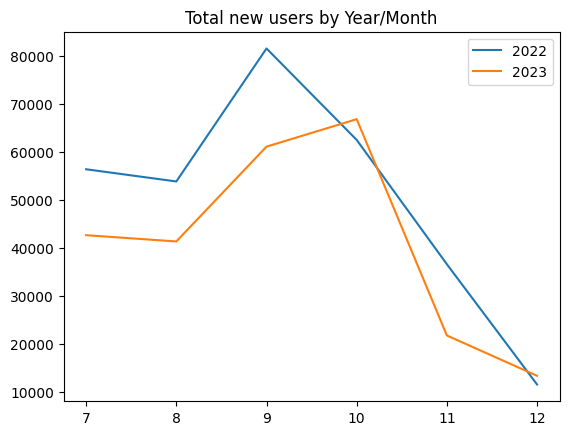

In [111]:
df_newb22 = df_newb.loc[df_newb['가입일시'].dt.year == 2022]
df_newb23 = df_newb.loc[df_newb['가입일시'].dt.year == 2023]


fig, axes = plt.subplots()

axes1 = plt.plot(df_newb22['가입일시'].dt.month, df_newb22['가입건수'])
axes2 = plt.plot(df_newb23['가입일시'].dt.month, df_newb23['가입건수'])

axes.set_title('Total new users by Year/Month')
axes.legend(['2022', '2023'])

plt.show()

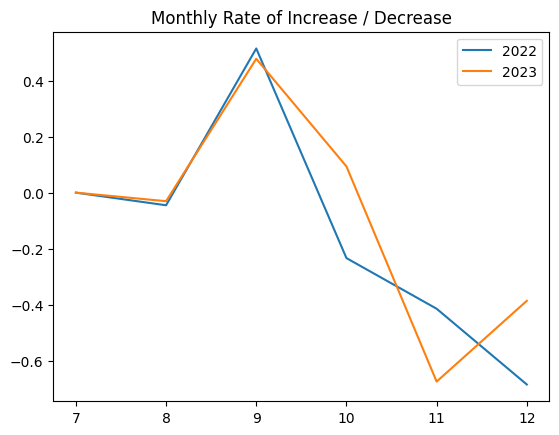

In [120]:
def calculate_monthly_change(df, col_name):
    df_ = df.copy()
    df_[f'{col_name}_증가폭'] = df_[col_name].pct_change().fillna(0)
    # df_['가입건수_증가폭'] = df_['가입건수'].diff().fillna(0)
    return df_

df_newb22_diff = calculate_monthly_change(df_newb22, '가입건수')
df_newb23_diff = calculate_monthly_change(df_newb23, '가입건수')

fig, axes = plt.subplots()

axes1 = plt.plot(df_newb22_diff['가입일시'].dt.month, df_newb22_diff['가입건수_증가폭'])
axes2 = plt.plot(df_newb23_diff['가입일시'].dt.month, df_newb23_diff['가입건수_증가폭'])

axes.set_title('Monthly Rate of Increase / Decrease')
axes.legend(['2022', '2023'])

plt.show()

Things to consider: Trend, Seasonality, Cycle, Variation

## 대여이력 변화 폭

In [121]:
print(f"{df_rental.columns = }")

df_rental.columns = Index(['자전거번호', '대여일시', '이용시간(분)', '이용거리(M)', '생년', '이용자종류', '대여대여소ID',
       '반납대여소ID', '나이(만)'],
      dtype='object')


In [134]:
df_rental_group = df_rental.groupby([df_rental['대여일시'].dt.year, df_rental['대여일시'].dt.month]).agg({'자전거번호':'size'})
df_rental_group

자전거번호
대여일시 대여일시         
2022 7     2185607
     8     1932567
     9     2596183
     10    2409618
     11    2033630
     12     874996
2023 7     2059019
     8     2032650
     9     2432777
     10    2864423
     11    1700221
     12    1055108

In [167]:
df_rental_group = pd.pivot_table(df_rental, index=df_rental['대여일시'].dt.month, columns=df_rental['대여일시'].dt.year, values=['자전거번호'], aggfunc='size')
df_rental = pd.DataFrame(df_rental_group).reset_index(names=['대여일시_월'])

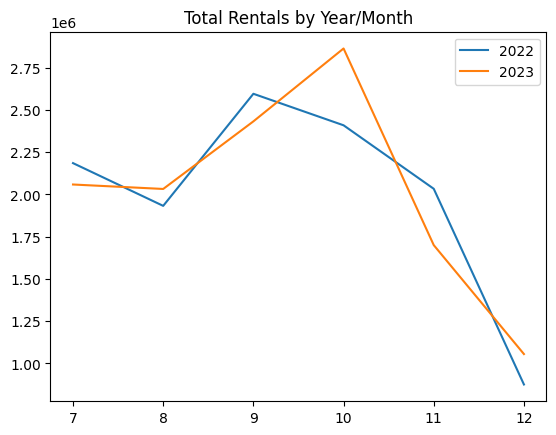

In [170]:
df_rental22 = df_rental.loc[:,['대여일시_월', 2022]]
df_rental23 = df_rental.loc[:, ['대여일시_월', 2023]]


fig, axes = plt.subplots()

axes1 = plt.plot(df_rental22['대여일시_월'], df_rental22[2022])
axes2 = plt.plot(df_rental23['대여일시_월'], df_rental23[2023])

axes.set_title('Total Rentals by Year/Month')
axes.legend(['2022', '2023'])

plt.show()

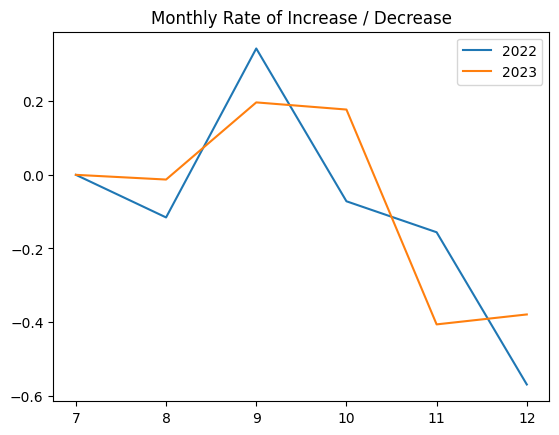

In [172]:
def calculate_monthly_change(df, col_name):
    df_ = df.copy()
    df_[f'{col_name}_증가폭'] = df_[col_name].pct_change().fillna(0)
    # df_['가입건수_증가폭'] = df_['가입건수'].diff().fillna(0)
    return df_

df_rental22_diff = calculate_monthly_change(df_rental22, 2022)
df_rental23_diff = calculate_monthly_change(df_rental23, 2023)

fig, axes = plt.subplots()

axes1 = plt.plot(df_rental22_diff['대여일시_월'], df_rental22_diff['2022_증가폭'])
axes2 = plt.plot(df_rental23_diff['대여일시_월'], df_rental23_diff['2023_증가폭'])

axes.set_title('Monthly Rate of Increase / Decrease')
axes.legend(['2022', '2023'])

plt.show()

1. 전체 2022, 2023년도 T-test
2. 월별로 2022, 2023년도 반복 아노바 검정

<img src='7E63CCE3-E278-46D6-BA26-807DDAC00D17.png'>

In [ ]:
import pandas as pd 
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.anova import AnovaRM

In [ ]:
from scipy import stats
t_stat_use, p_value_use = stats.ttest_ind(monthly_counts_2022['이용건수'], monthly_counts_2023['이용건수'], equal_var=False)

```
3팀 분석방향 

1. 시계열 그래프 추세 시각화 -> 2022년과 2023년 패턴이 다르다는 것을 발견 (평균과 분산 확인) 


2. 두 연도간의 비교 
2-1. t-test : 연간 평균 가입자 수를 비교 (정규성 가정이 충족되지 않을 경우, Mann-Whitney U test와 같은 비모수 검정)
2-2. 반복측정 anova : 월 별 비교 


3. 요금 인상 전 후의 비교 
3-1. t-test : 8월 인상 전 후, 10월 인상 전 후 
3-2. anova : 인상 전, 첫 인상 후, 두 번째 인상 후 
3-3. 시계열 분해 : 추세, 계절성, 불규칙성으로 분해 (요금 인상 전 후로 추세가 변했는지, 불규칙적인 변동이 커졌는지 확인) 
- 추세 > 장기적인 흐름 (가입자 수가 시간이 지남에 따라 증가/감소 하는지) 
- 계절성 > 패턴 (특정 달에 가입자 수가 항상 더 많은지/적은지) 
- 불규칙성 > 일시적 변동이나 특정 이벤트 (잔차) 

# 참고 
from statsmodels.tsa.seasonal import seasonal_decompose

# 시계열 분해 (additive 모델 사용)
decomposition = seasonal_decompose(series, model='additive')

# 잔차 데이터 추출
residuals = decomposition.resid


3-4. ITS : 특정 사건이 시계열 데이터에서 미친 영향을 심도있게 분석 가능 

https://hyemstat.tistory.com/entry/%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-Interrupted-Time-Series-Tutorial
```